# Evacuation Planning Simulation for Suzu City

This notebook implements an evacuation planning simulation for Suzu city (珠洲市) in Ishikawa Prefecture, Japan.

## City Information:
- Population: 13,531 (as of March 2021)
- Households: 6,013
- Population density: 54.6 persons per km²
- Total area: 247.20 km²

## Algorithms Used:
1. **Maximum Flow Problem**: To determine optimal evacuation routes and capacities
2. **Time-Expanded Network**: To model evacuation over time with dynamic constraints
3. **Combinatorial Optimization**: To find the best evacuation plan

## Simulation Components:
- Road network from OpenStreetMap
- Population distribution
- Evacuation shelters/safe zones
- Time-dependent evacuation flow


Libraries imported successfully!


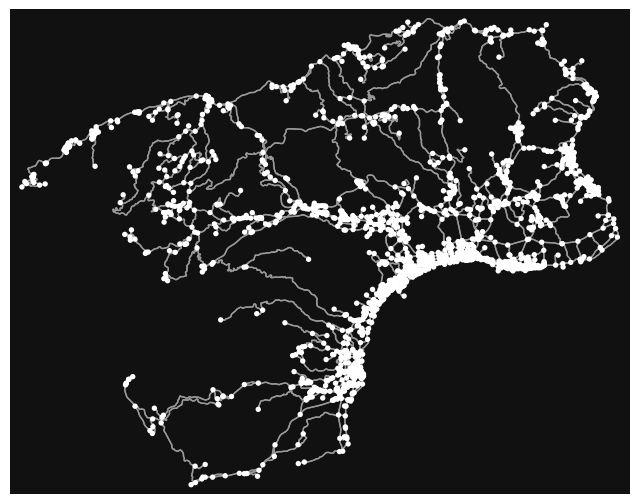

In [71]:
import osmnx as ox

import networkx as nx

import geopandas as gpd

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Animation imports
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display
import matplotlib.patches as patches

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")
place_name = "Suzu, Ishikawa, Japan"

graph = ox.graph_from_place(place_name, network_type='drive')

fig, ax = ox.plot_graph(graph)


In [72]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [73]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width',
       'est_width', 'access'],
      dtype='object')

In [74]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])


Network Statistics:
Number of nodes: 1861
Number of edges: 5043

Nodes columns: ['y', 'x', 'street_count', 'junction', 'highway', 'geometry']

Edges columns: ['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width', 'est_width', 'access']

Network bounds (lon_min, lat_min, lon_max, lat_max): [137.0884597  37.3614715 137.3601281  37.5294151]
u            v            key
1281068967   1281085627   0      475.433891
             1281088757   0      308.617274
             1281093936   0      527.876788
1281068968   1281110312   0       63.387881
             1281147637   0      145.787930
                                    ...    
11554332531  11554332523  0       77.406863
             11491062922  0       24.558301
12193918084  1281126546   0       32.597996
             9572654173   0      181.919245
             1281092623   0       65.842164
Name: length, Length: 5043, dtype: float64


In [75]:
# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self):
        self.total_population = 13531
        self.total_households = 6013
        self.city_area_km2 = 247.20
        self.population_density = 54.6  # persons per km²
        
        # Evacuation parameters
        self.evacuation_time_limit = random.randint(120, 240)  # Evacuation time limit in minutes
        0 # minutes
        self.time_step = 5  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        self.evacuation_modes = ['walking', 'driving']
        
        # Capacity parameters
        self.road_capacity_per_meter = 0.5  # persons per meter of road width
        self.default_road_width = 4  # meters
        
params = EvacuationParameters()
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Evacuation Time Limit: {params.evacuation_time_limit} minutes")
print(f"Time Steps: {params.time_step} minutes")

Evacuation Parameters:
Total Population: 13,531
Evacuation Time Limit: 201 minutes
Time Steps: 5 minutes


In [76]:
# Create population distribution across nodes
def distribute_population(nodes, total_population, method):
    """Distribute population across network nodes"""
    if method == 'random':
        # Randomly distribute population with some nodes having higher density
        weights = np.random.exponential(1, len(nodes))
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
        
    elif method == 'central':
        # Higher population in central areas
        center_lon = nodes.geometry.x.mean()
        center_lat = nodes.geometry.y.mean()
        
        distances = np.sqrt((nodes.geometry.x - center_lon)**2 + 
                           (nodes.geometry.y - center_lat)**2)
        weights = 1 / (1 + distances / distances.max())
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
    
    return population

# Distribute population
nodes['population'] = distribute_population(nodes, params.total_population, method='random')

# Ensure total population matches
total_assigned = nodes['population'].sum()
if total_assigned != params.total_population:
    diff = params.total_population - total_assigned
    # Add difference to the node with highest population
    max_pop_idx = nodes['population'].idxmax()
    nodes.loc[max_pop_idx, 'population'] += diff

print(f"Population Distribution:")
print(f"Total population assigned: {nodes['population'].sum():,}")
print(f"Max population at single node: {nodes['population'].max():,}")
print(f"Average population per node: {nodes['population'].mean():.1f}")
print(f"Nodes with population > 0: {(nodes['population'] > 0).sum()}")

Population Distribution:
Total population assigned: 13,531
Max population at single node: 979
Average population per node: 7.3
Nodes with population > 0: 1596


In [77]:
# Define real shelter locations (NAME, LONGITUDE, LATITUDE)
# !!! IMPORTANT: You need to replace these with your actual geocoded data !!!
# Example format: shelter_data = [
#    ("Misaki Elementary School", 137. Misaki_Elem_Lon, 37.Misaki_Elem_Lat),
#    ("Misaki Junior High School", 137.Misaki_JH_Lon, 37.Misaki_JH_Lat),
#    # ... add all your shelters here
# ]
# For now, using a placeholder. Replace this with your actual data.
shelter_data = [
    ("Misaki Elementary School", 137.3386079 ,37.4865063),
    ("Misaki Junior High School", 137.3421125, 37.4735508),
    ("Misaki Kominkan", 137.3417233 ,37.4741329, ),
    ("Misaki Day service Center", 137.3411659,37.4682916 ),
    ("Former Kodomari Elementary School", 137.3579202 ,37.4512824),
    # ("Bishouen", 137.3308802, 37.4001925),
    # ("Former Hon Elementary School", 137.3688191, 37.4087131),
    # ("Wakayama Elementary School", 137.3385077, 37.4328363),
    # ("Wakayama Kominkan", 137.3385751, 37.4328829),
    # ("Former Kamikuromaru Elementary School", 137.3559104, 37.4475454),
    # ("Naminohana Day Service Center Satellite", 137.3570625, 37.4517377),
    # ("Uedo Kominkan", 137.3116847, 37.4116036),
    # ("Uedo Elementary School", 137.3115456, 37.4118944),
    # ("Shoin Kominkan", 137.2889246, 37.3976377),
    # ("Shoin Elementary School", 137.2917720, 37.3986065),
    # ("Former Iizuka Nursery school", 137.3006094, 37.4042852),
    # ("Hioki Kominkan", 137.2755255, 37.3725516),
    # ("Naminohana Day Service Center", 137.2657426, 37.3537244),
    # ("Otani Sho Junior High School", 137.2801453, 37.3667500),
    # ("Otani Kominkan", 137.2797683, 37.3664723),
    # ("Takojima Kominkan", 137.3970876, 37.4428060),
    # ("Takojima Elementary School", 137.3969563, 37.4431527),
    # ("Iida Kominkan", 137.4204561, 37.4158499),
    # ("Iida Elementary School", 137.4214516, 37.4162095),
    # ("Horyu Kominkan", 137.3150532, 37.3392415),
    # ("Horyu Elementary and Junior High School", 137.3201452, 37.3421526),
    # ("Daisan Chojuen", 137.3204908, 37.3420836),
    # ("Former Horyu Elementary School", 137.3101570, 37.3359656),
    # ("Chojuen", 137.3142718, 37.3387864),
    # ("Midorigaoka Junior High School", 137.3562660, 37.3103234),
    # ("Tada Elementary School", 137.3561655, 37.3094892),
    # ("Tada Kominkan", 137.3570708, 37.3093952),
    # ("Daini Chojuen", 137.2343991, 37.2847052),
    # ("Matsunami Elementary School", 137.2405626, 37.2872322),
    # ("Matsunami Junior High School", 137.2389650, 37.2858169),
    # ("Uchiura Gymnasium", 137.2355521, 37.2848420),
    # ("Shiromaru Community Facility", 137.2284989, 37.2625297),
    # ("Noto Worker Plaza", 137.1990423, 37.2345812),
    # ("Ogi Junior High School", 137.2023565, 37.2307525),
    # ("Ogi Area Exchange Center", 137.2001550, 37.2306716),
    # ("Ogi Elementary School", 137.2027961, 37.2309856),
    # ("Hime Exchange Center", 137.1634898, 37.2275728),
    # ("Takakura Kominkan", 137.1633535, 37.2274938),
    # ("Former Mawaki Elementary School", 137.1354317, 37.2217836),
    # ("Elderly Rest House Tanagisou", 137.1264420, 37.2057072),
    # ("Shirasagi Nursery school", 137.1266014, 37.2059440),
    # ("Children Mirai Center", 137.1260841, 37.2057638),
    # ("Ushitsu Elementary School", 137.1272659, 37.2062591),
    # ("Noto Gymnasium", 137.1121106, 37.2027221),
    # ("Hibari Nursery school (Provisional Building)", 137.1105912, 37.2001969),
    # ("Sakiyama Sanson Kaihatsu Center", 137.1123188, 37.2027419),
    # ("Noto Junior High School", 137.1009139, 37.1996767),
    # ("Yanai Tennis Court", 137.0984857, 37.1983058),
    # ("Sannami Kominkan", 137.1194381, 37.2132718),
    # ("Noto Shichimi Health Welfare no Go Nagomi", 137.0506306, 37.1517450),
    # ("Ukawa Elementary School", 137.0422967, 37.1408108),
    # ("Ukawa Nursery school", 137.0423087, 37.1407304),
    # ("Ukawa Kominkan", 137.0423528, 37.1407340),
    # ("Omo Kominkan", 137.0927703, 37.1706693),
    # ("Yanagida Elementary School", 137.0789723, 37.1683838),
    # ("Yanagida Nursery school", 137.0789886, 37.1685458),
    # ("Concert Noto", 137.1260800, 37.2045585),
    # ("Jinno Kominkan", 137.1065759, 37.1950294),
    # ("Mizuho Kominkan", 137.1264420, 37.2057072),
    # ("Yanagida Junior High School", 137.0789723, 37.1683838),
    # ("Yanagida Gymnasium", 137.0789723, 37.1683838),
    # ("Yanagida Kominkan", 137.0789723, 37.1683838),
    # ("Kanmachi Kominkan", 137.1235335, 37.2064112),
    # ("Iwaido Kominkan", 137.0945935, 37.1705607),
    # ("Akiyoshi Kominkan", 137.0945037, 37.1705607),
    # ("Ishikawa Prefectural Noto Industry Gijutsu Semmonko", 137.2392465, 37.2872322),
    # ("Ishikawa Prefectural Noto High School", 137.1272659, 37.2062591),
    # ("Kanmachi Kominkan Goroku Branch Office", 137.1070267, 37.1856759),
    # ("Fudoji Kominkan", 137.0945935, 37.1705607),
    # ("Matsunami Kominkan", 137.2405626, 37.2872322)
]


# Misaki Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Awazu Ro Department 10-1

# Misaki Junior High School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Uji Yo Department 114

# Misaki Kominkan ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Uji Yo Department 114-13

# Misaki Day service Center ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Uji O Department 7

# Former Kodomari Elementary School ok
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Kodomari 33-7

# Bishouen
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi

# Former Hon Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Misakimachi Hon 17-47

# Wakayama Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Furukura 11 Department 100-1

# Wakayama Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Furukura Tora Department 60-1

# Former Kamikuromaru Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Kamikuromaru 10 Department 34

# Naminohana Day Service Center Satellite
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Wakayamamachi Kamikuromaru 429-4

# Uedo Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Uedomachi Jisha 257-1

# Uedo Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Uedomachi Jisha 574-2

# Shoin Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Shoinmachi Shoin 22 Department 2-1

# Shoin Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Shoinmachi Kawashiri 1 Department 39

# Former Iizuka Nursery school
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Shoinmachi Iizuka Ha Department 57

# Hioki Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Oritomachi Chi Department 34

# Naminohana Day Service Center
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Otanimachi 111-4

# Otani Sho Junior High School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Otanimachi 178

# Otani Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Otanimachi 257-4



# Takojima Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Takojimamachi Yo Department 139

# Takojima Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Takojimamachi Wa Department 69

# Iida Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Iidamachi 10 Department 20-2

# Iida Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Iidamachi 19 Department 61

# Horyu Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ukai U Department 46

# Horyu Elementary and Junior High School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ukai Ushi Department 83

# Daisan Chojuen
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ukai Ne 36-4

# Former Horyu Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Ushima 430

# Chojuen
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Horyumachi Kasugano 4117

# Midorigaoka Junior High School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Nonoemachi 6 no Department 1

# Tada Elementary School
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Nonoemachi Ni Department 38-2

# Tada Kominkan
#     Life / Living / Hospital
#     Ishikawa Suzu-shi Nonoemachi Ho Department 80-1

# Daini Chojuen
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Nunoura No 10-3

# Matsunami Elementary School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 15-80

# Matsunami Junior High School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 16-26

# Uchiura Gymnasium
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Nunoura Tsubuse 20-1

# Shiromaru Community Facility
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Shiromaru 2-17

# Noto Worker Plaza
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ossaka 11-51

# Ogi Junior High School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ogi 1-1-1

# Ogi Area Exchange Center
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ogi 15-30-1



# Ogi Elementary School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ogi 4-16

# Hime Exchange Center
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Hime 10-250

# Takakura Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Hime 12-36

# Former Mawaki Elementary School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Mawaki 33-25

# Elderly Rest House Tanagisou
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu U10-1

# Shirasagi Nursery school
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Futa 22

# Children Mirai Center
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Ta 46-1

# Ushitsu Elementary School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Mu 1

# Noto Gymnasium
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Sakiyama 1-1

# Hibari Nursery school (Provisional Building)
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Sakiyama 4-1

# Sakiyama Sanson Kaihatsu Center
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Sakiyama 1-1

# Noto Junior High School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Fujinami 14-35

# Yanai Tennis Court
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Fujinami 23-1

# Sannami Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Hanami 3-113

# Noto Shichimi Health Welfare no Go Nagomi
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Shichimi Tsu 100

# Ukawa Elementary School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ukawa 25-28

# Ukawa Nursery school
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ukawa 20-24

# Ukawa Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ukawa 18-128

# Omo Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho

# Yanagida Elementary School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Rei Department 2-1



# Yanagida Nursery school
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ro Department 245-1

# Concert Noto
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu To 29-2

# Jinno Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Tsurumachi 11-13-1

# Mizuho Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Mizuho 10-166

# Yanagida Junior High School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Rei Department 3

# Yanagida Gymnasium
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Yanagida Ume Department 55

# Yanagida Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Yanagida Nibu 54

# Kanmachi Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Kanmachi 8-505

# Iwaido Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Kurokawa 26-11

# Akiyoshi Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Akiyoshi 757-banchi

# Ishikawa Prefectural Noto Industry Gijutsu Semmonko
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 3-60-3

# Ishikawa Prefectural Noto High School
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Ushitsu Ma 106-banchi 7

# Kanmachi Kominkan Goroku Branch Office
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Goroku 2865-banchi

# Fudoji Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Fudoji 8200-banchi 1

# Matsunami Kominkan
#     Life / Living / Hospital
#     Ishikawa Hosu-gun Notocho Matsunami 1375-banchi 1



# Identify evacuation shelters/safe zones based on predefined coordinates
def identify_evacuation_shelters_from_coords(nodes, predefined_shelters):
    """Identify evacuation shelters by finding the nearest available network node to predefined coordinates."""
    shelter_node_ids = []
    assigned_nodes = set()  # Track already assigned nodes
    
    if not predefined_shelters:
        print("No predefined shelters provided.")
        return []

    print(f"Processing {len(predefined_shelters)} shelters...")
    
    for i, (name, lon, lat) in enumerate(predefined_shelters):
        # Calculate distances to all nodes
        distances = np.sqrt((nodes.geometry.x - lon)**2 + (nodes.geometry.y - lat)**2)
        
        # Sort nodes by distance to find the nearest available one
        sorted_nodes = distances.sort_values()
        
        assigned_node = None
        for node_id in sorted_nodes.index:
            if node_id not in assigned_nodes:
                # Found an unassigned node
                assigned_node = node_id
                break
        
        if assigned_node is not None:
            shelter_node_ids.append(assigned_node)
            assigned_nodes.add(assigned_node)
            # Store shelter name on the node
            nodes.loc[assigned_node, 'shelter_name'] = name
            
            # Calculate distance for reporting
            distance = distances.loc[assigned_node]
            print(f"  {i+1:2d}. '{name}' -> Node {assigned_node} (distance: {distance:.6f})")
        else:
            print(f"  WARNING: Could not find available node for '{name}'")
    
    print(f"Successfully assigned {len(shelter_node_ids)} shelters to unique nodes")
    return shelter_node_ids

# Identify shelters using the predefined list
# You will need to populate `shelter_data` with actual (name, lon, lat) tuples
shelter_nodes = identify_evacuation_shelters_from_coords(nodes, shelter_data)

nodes['is_shelter'] = False
if shelter_nodes:
    nodes.loc[shelter_nodes, 'is_shelter'] = True

print(f"Evacuation Shelters:")
print(f"Number of shelters: {len(shelter_nodes)}")
# If you stored names and want to print them:
# for node_id in shelter_nodes:
# print(f"  Node ID: {node_id}, Name: {nodes.loc[node_id].get('shelter_name', 'N/A')}")
print(f"Shelter node IDs: {shelter_nodes}")


# Add capacity to shelters
nodes['shelter_capacity'] = 0 
if shelter_nodes: # Only assign capacities if shelters were identified
    shelter_capacities = np.random.randint(50, 151, size=len(shelter_nodes))
    nodes.loc[shelter_nodes, 'shelter_capacity'] = shelter_capacities
    print(f"Total shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].sum():,}")
    print(f"Average shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].mean():.1f}")
    print(f"Min shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].min()}")
    print(f"Max shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].max()}")
else:
    print("No shelters identified, so no capacities assigned.")

print(f"\\nDetailed shelter information:")
if shelter_nodes:
    shelter_info = nodes.loc[shelter_nodes, ['population', 'is_shelter', 'shelter_capacity', 'shelter_name']].copy()
    shelter_info.index.name = 'Node ID'
    print(shelter_info.sort_values('shelter_capacity', ascending=False))
else:
    print("No shelter information to display.")

Processing 5 shelters...
   1. 'Misaki Elementary School' -> Node 3762984021 (distance: 0.001070)
   2. 'Misaki Junior High School' -> Node 11506868426 (distance: 0.001034)
   3. 'Misaki Kominkan' -> Node 1281075355 (distance: 0.000684)
   4. 'Misaki Day service Center' -> Node 1281148941 (distance: 0.000908)
   5. 'Former Kodomari Elementary School' -> Node 1281148891 (distance: 0.000632)
Successfully assigned 5 shelters to unique nodes
Evacuation Shelters:
Number of shelters: 5
Shelter node IDs: [3762984021, 11506868426, 1281075355, 1281148941, 1281148891]
Total shelter capacity: 613
Average shelter capacity: 122.6
Min shelter capacity: 71
Max shelter capacity: 145
\nDetailed shelter information:
             population  is_shelter  shelter_capacity  \
Node ID                                                 
3762984021            2        True               145   
1281148891            0        True               138   
1281075355            0        True               135   
1150686

In [78]:
# Calculate edge capacities and travel times
def calculate_edge_properties(edges, params):
    """Calculate capacity and travel time for each edge"""
    # Convert to numeric values, handling string values
    width_series = pd.to_numeric(edges['width'], errors='coerce')
    est_width_series = pd.to_numeric(edges['est_width'], errors='coerce')
    edges['width_calc'] = width_series.fillna(est_width_series).fillna(params.default_road_width)
    
    # Calculate capacity based on road width and length
    edges['capacity'] = (edges['width_calc'] * edges['length'] * params.road_capacity_per_meter / 100).astype(int)
    edges['capacity'] = edges['capacity'].clip(lower=10)  # Ensure minimum capacity of 10   
    
    # Calculate travel times (in minutes)
    # Walking time
    edges['walk_time'] = (edges['length'] / 1000) / params.walking_speed * 60  # minutes
    
    # Driving time (use maxspeed if available)
    max_speeds = edges['maxspeed'].fillna(params.driving_speed)
    # Convert string speeds to numeric
    max_speeds = pd.to_numeric(max_speeds, errors='coerce').fillna(params.driving_speed)
    edges['drive_time'] = (edges['length'] / 1000) / max_speeds * 60  # minutes
    
    return edges

# Calculate edge properties
edges = calculate_edge_properties(edges, params)

print(f"Edge Properties:")
print(f"Capacity - Min: {edges['capacity'].min()}, Max: {edges['capacity'].max()}, Mean: {edges['capacity'].mean():.1f}")
print(f"Walk time - Min: {edges['walk_time'].min():.2f}, Max: {edges['walk_time'].max():.2f} minutes")
print(f"Drive time - Min: {edges['drive_time'].min():.2f}, Max: {edges['drive_time'].max():.2f} minutes")

Edge Properties:
Capacity - Min: 10, Max: 112, Mean: 11.2
Walk time - Min: 0.01, Max: 67.27 minutes
Drive time - Min: 0.00, Max: 11.21 minutes


In [79]:
# Add west exit point to the evacuation network
def add_west_exit(nodes, edges, graph):
    """Add a west exit point for evacuation"""
    # Find the westernmost area of the city
    west_lon = nodes.geometry.x.min()
    
    # Find nodes in the western 15% of the area
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    west_threshold = west_lon + (lon_range * 0.15)
    
    # Get nodes in the western area
    west_nodes = nodes[nodes.geometry.x <= west_threshold]
    
    # Select the westernmost node as the exit point
    west_exit_node = west_nodes.geometry.x.idxmin()
    
    # Mark this node as a west exit
    nodes.loc[west_exit_node, 'is_west_exit'] = True
    nodes.loc[west_exit_node, 'exit_capacity'] = 10000
    
    print(f"West exit created at node {west_exit_node}")
    print(f"Exit location: ({nodes.loc[west_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_exit_node, 'geometry'].y:.4f})")
    
    return west_exit_node

# Initialize exit columns if they don't exist
if 'is_west_exit' not in nodes.columns:
    nodes['is_west_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

def add_south_exit(nodes, edges, graph):
    """Add a south exit point for evacuation"""
    # Find the southernmost area of the city
    south_lat = nodes.geometry.y.min()
    

    lat_range = nodes.geometry.y.max() - nodes.geometry.y.min()
    south_threshold = south_lat + lat_range 
    
    # Get nodes in the southern area
    south_nodes = nodes[nodes.geometry.y <= south_threshold]
    
    # Select the southernmost node as the exit point
    south_exit_node = south_nodes.geometry.y.idxmin()
    
    # Mark this node as a south exit
    nodes.loc[south_exit_node, 'is_south_exit'] = True
    nodes.loc[south_exit_node, 'exit_capacity'] = 10000
    
    print(f"South exit created at node {south_exit_node}")
    print(f"Exit location: ({nodes.loc[south_exit_node, 'geometry'].x:.4f}, {nodes.loc[south_exit_node, 'geometry'].y:.4f})")
    
    return south_exit_node

def add_west_south_exit(nodes, edges, graph):
    """Add a west-south exit point for evacuation in the southwestern area"""
    # Find the southwestern area of the city
    west_lon = nodes.geometry.x.min()
    south_lat = nodes.geometry.y.min()
    

    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    lat_range = nodes.geometry.y.max() - nodes.geometry.y.min()
    
    west_threshold = west_lon + (lon_range )
    south_threshold = south_lat + lat_range 
    
    # Get nodes in the southwestern area
    southwest_nodes = nodes[
        (nodes.geometry.x <= west_threshold) & 
        (nodes.geometry.y <= south_threshold)
    ]
    
    if len(southwest_nodes) == 0:
        # If no nodes in the strict southwestern area, expand the search
        west_threshold = west_lon + (lon_range * 0.3)
        south_threshold = south_lat + (lat_range * 0.3)
        southwest_nodes = nodes[
            (nodes.geometry.x <= west_threshold) & 
            (nodes.geometry.y <= south_threshold)
        ]
    
    # Select the node that is closest to the southwest corner
    if len(southwest_nodes) > 0:
        # Calculate distance to southwest corner
        distances = np.sqrt(
            (southwest_nodes.geometry.x - west_lon)**2 + (southwest_nodes.geometry.y - south_lat)**2
        )
        west_south_exit_node = distances.idxmin()
    else:
        # Fallback: select the westernmost node among the southernmost nodes
        south_nodes = nodes[nodes.geometry.y <= south_lat + (lat_range * 0.15)]
        west_south_exit_node = south_nodes.geometry.x.idxmin()
    
    # Mark this node as a west-south exit
    nodes.loc[west_south_exit_node, 'is_west_south_exit'] = True
    nodes.loc[west_south_exit_node, 'exit_capacity'] = 10000 
    
    print(f"West-South exit created at node {west_south_exit_node}")
    print(f"Exit location: ({nodes.loc[west_south_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_south_exit_node, 'geometry'].y:.4f})")
    
    return west_south_exit_node

# Initialize exit columns if they don't exist
if 'is_south_exit' not in nodes.columns:
    nodes['is_south_exit'] = False
if 'is_west_south_exit' not in nodes.columns:
    nodes['is_west_south_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

add_west_exit(nodes, edges, graph)
add_south_exit(nodes, edges, graph)
add_west_south_exit(nodes, edges, graph)


West exit created at node 1281123728
Exit location: (137.0885, 37.4693)
South exit created at node 1281070506
Exit location: (137.1657, 37.3615)
West-South exit created at node 1281069767
Exit location: (137.1401, 37.3899)


np.int64(1281069767)

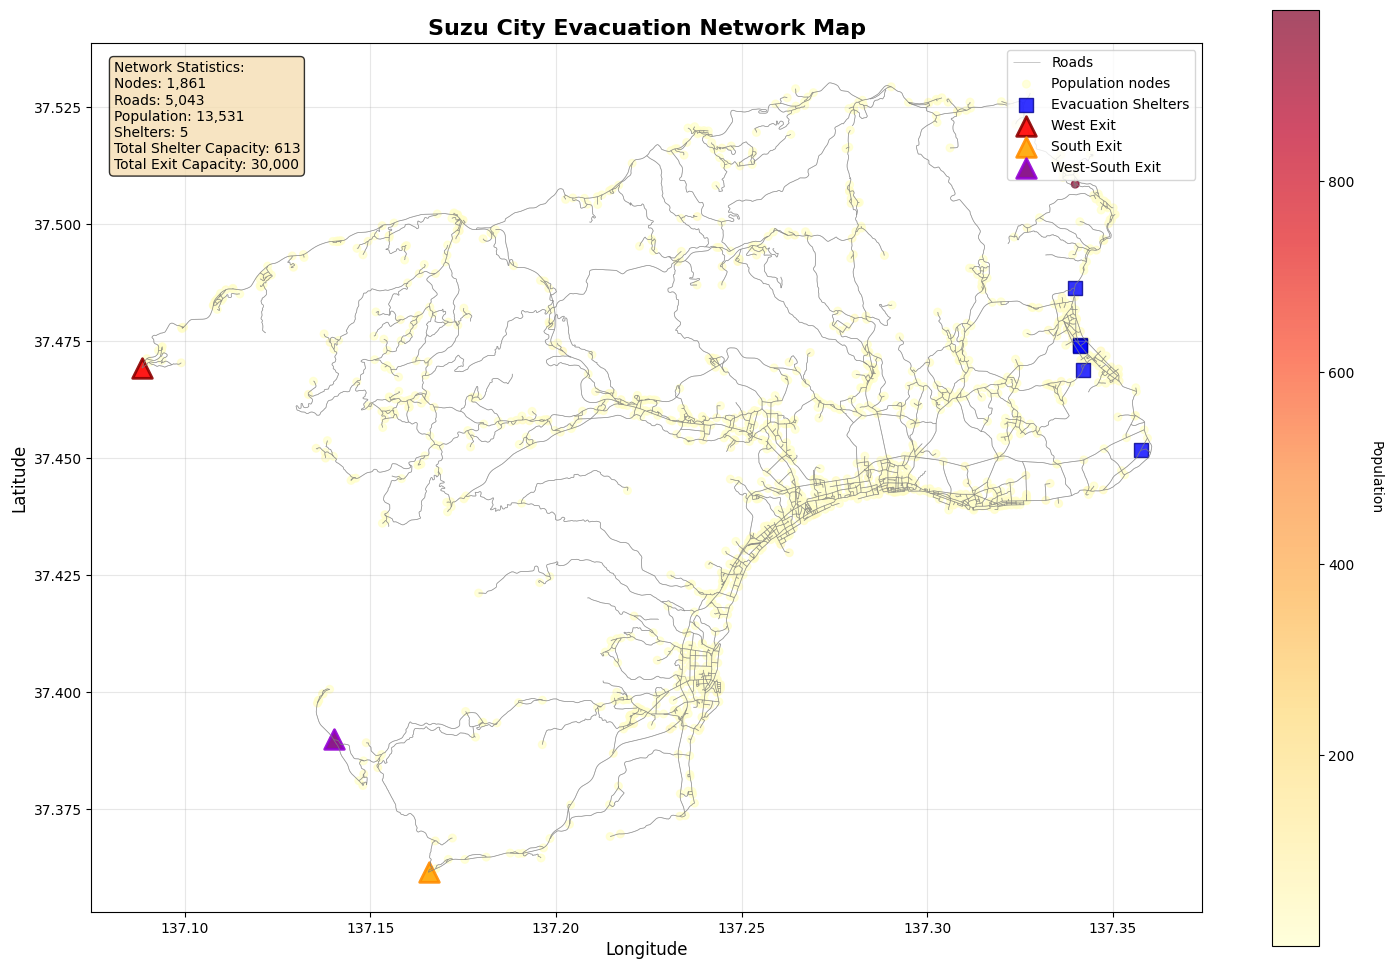

In [ ]:
# Create a comprehensive map showing the evacuation network
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot the road network
edges.plot(ax=ax, linewidth=0.5, alpha=0.6, color='gray', label='Roads')

# Plot all nodes with population
nodes_with_pop = nodes[nodes['population'] > 0]
scatter = ax.scatter(nodes_with_pop.geometry.x, nodes_with_pop.geometry.y, 
                                        c=nodes_with_pop['population'], cmap='YlOrRd', 
                                        s=30, alpha=0.7, label='Population nodes')

# Plot evacuation shelters
shelter_nodes_data = nodes[nodes['is_shelter']]
ax.scatter(shelter_nodes_data.geometry.x, shelter_nodes_data.geometry.y, 
                  c='blue', s=50, marker='s', alpha=0.8, label='Evacuation Shelters', 
                  edgecolors='darkblue', linewidth=1)

# Plot west exit
west_exit_data = nodes[nodes['is_west_exit']]
ax.scatter(west_exit_data.geometry.x, west_exit_data.geometry.y, 
                  c='red', s=200, marker='^', alpha=0.9, label='West Exit', 
                  edgecolors='darkred', linewidth=2)

# Plot south exit
south_exit_data = nodes[nodes['is_south_exit']]
ax.scatter(south_exit_data.geometry.x, south_exit_data.geometry.y, 
                  c='orange', s=200, marker='^', alpha=0.9, label='South Exit', 
                  edgecolors='darkorange', linewidth=2)

# Plot west-south exit
west_south_exit_data = nodes[nodes['is_west_south_exit']]
ax.scatter(west_south_exit_data.geometry.x, west_south_exit_data.geometry.y, 
                  c='purple', s=200, marker='^', alpha=0.9, label='West-South Exit', 
                  edgecolors='darkviolet', linewidth=2)

# Add colorbar for population
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Population', rotation=270, labelpad=20)

# Add title and labels
ax.set_title('Suzu City Evacuation Network Map', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Add grid
ax.grid(True, alpha=0.3)

# Calculate correct exit capacities
total_exit_capacity = nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum()

# Add statistics text box
stats_text = f"""Network Statistics:
Nodes: {len(nodes):,}
Roads: {len(edges):,}
Population: {nodes['population'].sum():,}
Shelters: {len(shelter_nodes)}
Total Shelter Capacity: {nodes['shelter_capacity'].sum():,}
Total Exit Capacity: {total_exit_capacity:,}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()